In [1]:
# Cell 1: Imports and Setup
import os
import torch
import torchaudio
import argparse
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from s3prl.hub import distilhubert
from s3prl.optimizers import WarmupLinearSchedule
import time

# Allowlist required classes for torch.load
torch.serialization.add_safe_globals([WarmupLinearSchedule, argparse.Namespace])

# Set random seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/home/lucky/anaconda3/envs/diarization/lib/python3.9/site-packages/s3prl/upstream/byol_s/byol_a/common.py:20: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")
ESPnet is not installed, cannot use espnet_hubert upstream


Using device: cuda


In [2]:
# Cell 2: Load pretrained model
pretrained_model = distilhubert().to(device)

# Emotion class mapping
emotion_classes = {
    0: "happy",
    1: "sad",
    2: "angry",
    3: "fear",
    4: "disgust",
    5: "neutral"
}

[UpstreamExpert] - Using the default upstream expert config
[DistillerModel] - Expands the output dimension by 3 times
[DistillerModel] - Pred layers: [4, 8, 12]
[TransformerEncoder] - Attention type = original


/home/lucky/anaconda3/envs/diarization/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[DistillerModel] - Out layer type: expand-last
[DistillerModel] - Inter dim = 768


In [3]:
class EmotionDataset(Dataset):
    def __init__(self, audio_dir, labels_file, max_duration=10.0, augment=False):
        self.audio_files = []
        self.labels = []
        self.max_samples = int(16000 * max_duration)
        self.augment = augment

        with open(labels_file, 'r') as file:
            next(file)
            for line in file:
                columns = line.strip().split(',')
                audio_file = columns[0]
                emotion = columns[3]
                path = os.path.join(audio_dir, audio_file)
                if os.path.exists(path):
                    self.audio_files.append(path)
                    self.labels.append(self.emotion_to_label(emotion))
                else:
                    print(f"Missing file: {path}")

    def emotion_to_label(self, emotion):
        return {"HAP": 0, "SAD": 1, "ANG": 2, "FEA": 3, "DIS": 4, "NEU": 5}.get(emotion, -1)

    def __len__(self):
        return len(self.audio_files)

    def augment_waveform(self, waveform):
        # Random gain
        if random.random() < 0.5:
            gain_db = random.uniform(-6, 6)
            waveform = waveform * (10 ** (gain_db / 20))

        # Add Gaussian noise
        if random.random() < 0.5:
            noise = torch.randn_like(waveform) * 0.005
            waveform = waveform + noise

        # Pitch shift (simulate by resample)
        if random.random() < 0.5:
            shift = random.randint(-2, 2)
            new_freq = int(16000 * (2.0 ** (shift / 12)))
            waveform = torchaudio.transforms.Resample(orig_freq=16000, new_freq=new_freq)(waveform)
            waveform = torchaudio.transforms.Resample(orig_freq=new_freq, new_freq=16000)(waveform)

        # Random time shift
        if random.random() < 0.5:
            shift = int(16000 * random.uniform(-0.2, 0.2))
            waveform = torch.roll(waveform, shifts=shift)

        return waveform

    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.audio_files[idx])
        if sample_rate != 16000:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
        waveform = waveform.squeeze(0)[:self.max_samples]

        if self.augment:
            waveform = self.augment_waveform(waveform)

        return waveform, self.labels[idx]


In [4]:
# Cell 4: Collate Function
def collate_fn(batch):
    waveforms, labels = zip(*batch)
    waveforms = pad_sequence(waveforms, batch_first=True)
    labels = torch.tensor(labels)
    return waveforms, labels


In [5]:
# Cell 5: Load Data
train_dir = "/home/lucky/Documents/research/dataset/train"
val_dir = "/home/lucky/Documents/research/dataset/val"
test_dir = "/home/lucky/Documents/research/dataset/test"

train_labels_file = "/home/lucky/Documents/research/dataset/train.csv"
val_labels_file = "/home/lucky/Documents/research/dataset/val.csv"
test_labels_file = "/home/lucky/Documents/research/dataset/test.csv"

# ✅ Enable augmentation only for training dataset
train_dataset = EmotionDataset(train_dir, train_labels_file, augment=True)
val_dataset = EmotionDataset(val_dir, val_labels_file, augment=False)
test_dataset = EmotionDataset(test_dir, test_labels_file, augment=False)

print(f"Train set: {len(train_dataset)}")
print(f"Val set: {len(val_dataset)}")
print(f"Test set: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=collate_fn)  # Reduced batch size to 1 to avoid OOM
val_loader = DataLoader(val_dataset, batch_size=10, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=10, collate_fn=collate_fn)


Train set: 5209
Val set: 1116
Test set: 1117


In [6]:

# Cell 6: Classifier
import torch.nn as nn
class EmotionClassifier(nn.Module):
    def __init__(self, input_dim=768, num_classes=6):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

classifier = EmotionClassifier().to(device)

In [7]:
# Cell 7: Training Loop
optimizer = torch.optim.AdamW(list(pretrained_model.parameters()) + list(classifier.parameters()), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

epochs = 20
for epoch in range(epochs):
    pretrained_model.train()
    classifier.train()
    total_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        optimizer.zero_grad()
        results = pretrained_model(waveforms)
        features = results["paper"]  # shape: (B, T, D)
        pooled = features.mean(dim=1)  # shape: (B, D) — average across time
        logits = classifier(pooled)

        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        torch.cuda.empty_cache()  # Explicitly clear cache to help with fragmentation

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}, Time={time.time() - start_time:.2f}s")


Epoch 1: Loss=1.5239, Accuracy=0.3872, Time=14855.47s
Epoch 2: Loss=1.2754, Accuracy=0.5036, Time=15637.95s
Epoch 3: Loss=1.1402, Accuracy=0.5694, Time=15353.80s
Epoch 4: Loss=1.0502, Accuracy=0.6038, Time=15390.79s
Epoch 5: Loss=0.9875, Accuracy=0.6303, Time=16237.62s
Epoch 6: Loss=0.9232, Accuracy=0.6533, Time=14105.39s
Epoch 7: Loss=0.8738, Accuracy=0.6790, Time=16614.98s
Epoch 8: Loss=0.8270, Accuracy=0.6957, Time=12075.31s
Epoch 9: Loss=0.7893, Accuracy=0.7178, Time=11953.35s
Epoch 10: Loss=0.7381, Accuracy=0.7295, Time=11360.73s
Epoch 11: Loss=0.7006, Accuracy=0.7474, Time=15438.64s
Epoch 12: Loss=0.6724, Accuracy=0.7604, Time=15855.34s
Epoch 13: Loss=0.6370, Accuracy=0.7710, Time=14326.60s
Epoch 14: Loss=0.6020, Accuracy=0.7917, Time=15847.48s
Epoch 15: Loss=0.5760, Accuracy=0.7902, Time=13744.96s
Epoch 16: Loss=0.5560, Accuracy=0.7994, Time=16276.44s
Epoch 17: Loss=0.5075, Accuracy=0.8199, Time=14875.95s
Epoch 18: Loss=0.4930, Accuracy=0.8207, Time=15743.56s
Epoch 19: Loss=0.46

In [8]:
# Cell 8: Evaluation
test_preds, test_labels = [], []
classifier.eval()
pretrained_model.eval()
start = time.time()

with torch.no_grad():
    for waveforms, labels in test_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)
        results = pretrained_model(waveforms)
        features = results["paper"]
        pooled = features.mean(dim=1)
        logits = classifier(pooled)
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

end = time.time()
accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
inference_time = (end - start) / len(test_loader.dataset)
model_size = sum(p.numel() for p in classifier.parameters() if p.requires_grad) * 4 / (1024**2)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print(f"Inference time/sample: {inference_time:.4f}s, Model size: {model_size:.2f}MB")


Test Accuracy: 0.7064
Precision: 0.7167, Recall: 0.7064, F1: 0.7036
Inference time/sample: 0.0214s, Model size: 0.02MB


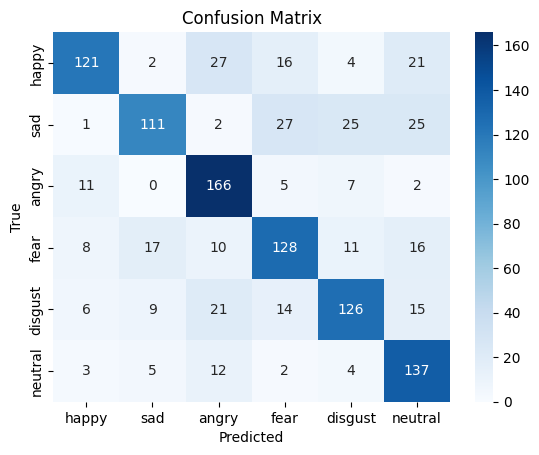

In [9]:
# Cell 9: Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(emotion_classes.values()), yticklabels=list(emotion_classes.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Cell 10: Save Model
torch.save(classifier.state_dict(), "distilhubert_emotion_recognition.pth")
